In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
from pathlib import Path
import base64
import cv2
import matplotlib.pyplot as plt
import json 
from tqdm.notebook import tqdm 
import scipy 
from joblib import Parallel , delayed

In [ ]:
!unzip -qq "drive/MyDrive/Datasets/lesion_detection.zip"

In [ ]:
IMG_SIZE = 224
base_path = Path('')
train_path = list((base_path / 'train').glob('*.json'))
test_path = list((base_path / 'test').glob('*.json'))

In [ ]:
label_info = pd.read_csv((base_path /'class_id_info.csv'))
categories = {i[0]:i[1]-1 for i in label_info.to_numpy()}
label_info

,class,class_id
0,01_ulcer,1
1,02_mass,2
2,04_lymph,3
3,05_bleeding,4


In [ ]:
def xyxy2coco(xyxy):
    x1,y1,x2,y2 =xyxy
    w,h =  x2-x1, y2-y1
    return [x1,y1,w,h] 


#center x, y, width, height
def xyxy2yolo(xyxy):
    
    x1,y1,x2,y2 =xyxy
    w,h =  x2-x1, y2-y1
    xc = x1 + int(np.round(w/2)) # xmin + width/2
    yc = y1 + int(np.round(h/2)) # ymin + height/2
    #정규화된 박스 중심과 너비, 높이
    return [ xc/IMG_SIZE, yc/IMG_SIZE, w/IMG_SIZE, h/IMG_SIZE ] 

def scale_bbox(img, xyxy):
    # Get scaling factor
    scale_x = IMG_SIZE/img.shape[1]
    scale_y = IMG_SIZE/img.shape[0]
    
    x1,y1,x2,y2 =xyxy
    x1 = int(np.round(x1*scale_x, 4))
    y1 = int(np.round(y1*scale_y, 4))
    x2 = int(np.round(x2*scale_x, 4))
    y2= int(np.round(y2*scale_y, 4))

    return [x1, y1, x2, y2] # xmin, ymin, xmax, ymax

def save_image_label(json_file, mode): 
    with open(json_file,'r') as f: 
        json_file =json.load(f)

    image_id = json_file['file_name'].replace('.json','')
    
    # decode image data
    image = np.frombuffer(base64.b64decode(json_file['imageData']), np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    cv2.imwrite(str(new_image_path / (image_id + '.png')) ,image)
    
    # extract bbox
    origin_bbox = []
    if mode == 'train':
        with open(new_label_path / (image_id + '.txt'), 'w') as f:
            for i in json_file['shapes']: 
                bbox = i['points'][0] + i['points'][2]
                origin_bbox.append(bbox)
                bbox = scale_bbox(image,bbox)
                bbox = xyxy2yolo(bbox)
                
                labels = [categories[i['label']]]+bbox
                f.writelines([f'{i} ' for i in labels] + ['\n']) 
    return origin_bbox

In [ ]:
import multiprocessing as mp 

# 저장할 파일 경로
save_path = Path('./train_data')
new_image_path = save_path / 'images' # image폴더 
new_label_path = save_path / 'labels' # label폴더

new_image_path.mkdir(parents=True,exist_ok=True)
new_label_path.mkdir(parents=True,exist_ok=True)

# data를 생성하기 위해 mlutiprocessing 적용
tmp = Parallel(n_jobs=mp.cpu_count(),prefer="threads")(delayed(save_image_label)(str(train_json),'train') for train_json in tqdm(train_path))

  0%|          | 0/62622 [00:00<?, ?it/s]

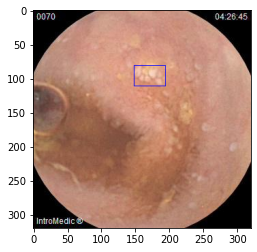

In [ ]:
n = 96
filename = train_path[n].name.replace('.json','.png')
sample = cv2.imread(f'./train_data/images/{filename}')[:,:,::-1].astype(np.uint8)
for i in tmp[n]: 
    i = list(map(int,i))
    sample = cv2.rectangle(sample,(i[0],i[1]),(i[2],i[3]),(0,0,255),1)
plt.imshow(sample)

In [ ]:
from sklearn.model_selection import train_test_split
# 학습 이미지가 많은 관계로 10000개만 사용
images_path = list(new_image_path.glob('*'))

train_path_list,valid_path_list = train_test_split(images_path,test_size=0.1,random_state=42)

In [ ]:
with open('train_dataset.txt', 'w') as f:
    f.writelines([f'{i}\n' for i in train_path_list])
with open('valid_dataset.txt', 'w') as f:
    f.writelines([f'{i}\n ' for i in valid_path_list]) 

In [ ]:
! pip install scipy --upgrade

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
! pip install -r ./yolov5/requirements.txt

In [ ]:
!pip install -q --upgrade wandb
# Login 
import wandb
wandb.login()

wandb: Currently logged in as: kimhwijin (use `wandb login --relogin` to force relogin)


True

In [ ]:
# Create .yaml file 
import yaml

data_yaml = dict(
    train = './train_dataset.txt',
    val = './valid_dataset.txt',
    nc = 4,
    names = ['01_ulcer','02_mass','04_lymph','05_bleeding']
)

# Note that I am creating the file in the yolov5/data/ directory.
with open('endoscopy.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [ ]:
!python ./yolov5/train.py --img 224 \
                          --batch 100\
                          --epochs 30\
                          --data ./endoscopy.yaml\
                          --weights ../input/ultralyticsyolov5aweights/yolov5s.pt\
                          --project yolov5-endoscopy\
                          --save-period 1\
                          --name endoscopy

Streaming output truncated to the last 5000 lines.
val: WARNING:  train_data/images/train_122274.png: ignoring corrupt image/label: [Errno 2] No such file or directory: ' train_data/images/train_122274.png'
val: WARNING:  train_data/images/train_122286.png: ignoring corrupt image/label: [Errno 2] No such file or directory: ' train_data/images/train_122286.png'
val: WARNING:  train_data/images/train_122287.png: ignoring corrupt image/label: [Errno 2] No such file or directory: ' train_data/images/train_122287.png'
val: WARNING:  train_data/images/train_122289.png: ignoring corrupt image/label: [Errno 2] No such file or directory: ' train_data/images/train_122289.png'
val: WARNING:  train_data/images/train_122292.png: ignoring corrupt image/label: [Errno 2] No such file or directory: ' train_data/images/train_122292.png'
val: WARNING:  train_data/images/train_122297.png: ignoring corrupt image/label: [Errno 2] No such file or directory: ' train_data/images/train_122297.png'
val: WARNING: